In [2]:
import torch
import torch.nn.functional as F

In [3]:
with open('./names.txt','r',encoding='utf-8') as f:
    words = f.read().splitlines()

In [4]:
len(words)

32033

In [5]:
chars = []
chars.append('.')
chars = chars+sorted(list(set(''.join(words))))
vocab_size = len(chars)

In [6]:
# 定义两个函数用以转换字符到数字和数字到字符
stoi = lambda x: chars.index(x)
itos = lambda x: chars[x]

In [7]:
block_size = 3
X,Y = [],[]
for w in words[:]:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi(ch)
        X.append(context)
        Y.append(ix)
        # print(''.join(itos(xi) for xi in context), '--->', itos(ix))
        context = context[1:] + [ix]
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [8]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [9]:
def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi(ch)
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [10]:
n_embed = 10
input_neurons = n_embed * block_size
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embed),generator=g)
# 将参数进行缩小，可以加速训练的收敛过程
# 这里将激活前的参数层进行缩小，使得整个层的原始输出值在tanh计算的时候是落在tanh梯度较大的位置，这样使得初始学习的时候所有的神经元都可以直接参与计算
# 注意现在这里使用的0.2是一个magic number，可以通过kaiming initialization来计算一个更符合数学规则的初始值（但是由于现代神经网络的很多优化方案（例如batch normalization），使得精确设置W的缩放规模并不那么重要了）
# 缩放的目的是，w的随机初始化是符合标准正态分布的，x的取数也是符合标准正态分布的，但是如果w和x的矩阵乘法，那么得到的y的标准差会变大，即整个正态分布的“山峰”的体会变宽，这会导致有部分y值到了tanh的饱和区，使得梯度消失，因此需要一个缩小因子，使得y的标准差变小，这样可以使得反向传播时梯度不会消失
# 现在使用kaiming initialization来计算一个更符合数学规则的权重初始值，使得x @ w之后的矩阵数值范围尽可能多的落在tanh函数的激活区间内，这样可以使得梯度不会消失
w1 = torch.randn((input_neurons,n_hidden),generator=g) * (5/3)/(input_neurons**0.5) #0.2
b1 = torch.randn(n_hidden,generator=g) * 0.01
# 将最后一层的权重缩小，这样可以将第一次的logits，即原始输出值缩小，这样所有的值都相当于平均在0附近，取样的概率相等，初始值loss可控
w2 = torch.randn((n_hidden,vocab_size),generator=g) * 0.01
b2 = torch.randn(vocab_size,generator=g) * 0

# 用于batch normalization的学习参数
bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))

# 用于batch normalization的运行时参数,因为是标准正态分布数据初始化，所以均值是0，标准差是1
bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))

parameters = [C,w1,b1,w2,b2,bngain,bnbias]
for p in parameters:
    p.requires_grad = True

In [11]:
sum(n.nelement() for n in parameters)

12297

mean of x is -0.002289424417540431,std of x is 1.0162497758865356
mean of y is -0.0029294616542756557,std of y is 1.008420705795288


(array([2.36900477e-05, 2.36899942e-05, 4.73800955e-05, 1.89519954e-04,
        2.36900477e-04, 6.15939850e-04, 6.63321337e-04, 1.44509128e-03,
        2.34531208e-03, 3.67195325e-03, 5.87512520e-03, 9.49969841e-03,
        1.33848770e-02, 2.14394690e-02, 3.27396090e-02, 4.73563519e-02,
        6.78008400e-02, 9.48074640e-02, 1.29466038e-01, 1.73789994e-01,
        2.24178669e-01, 2.81769189e-01, 3.42178663e-01, 3.90624811e-01,
        4.24904276e-01, 4.31703313e-01, 4.10477051e-01, 3.69706467e-01,
        3.13513826e-01, 2.47655479e-01, 1.94755662e-01, 1.46617623e-01,
        1.09353137e-01, 7.99301308e-02, 5.33025472e-02, 3.88279444e-02,
        2.63669933e-02, 1.63935130e-02, 1.17502504e-02, 6.70427594e-03,
        4.95121438e-03, 2.62959233e-03, 2.01365178e-03, 1.01867090e-03,
        4.50110399e-04, 4.50110907e-04, 1.89519954e-04, 9.47601910e-05,
        0.00000000e+00, 7.10701432e-05]),
 array([-5.32655859, -5.1154995 , -4.90443993, -4.69338083, -4.48232126,
        -4.27126217, 

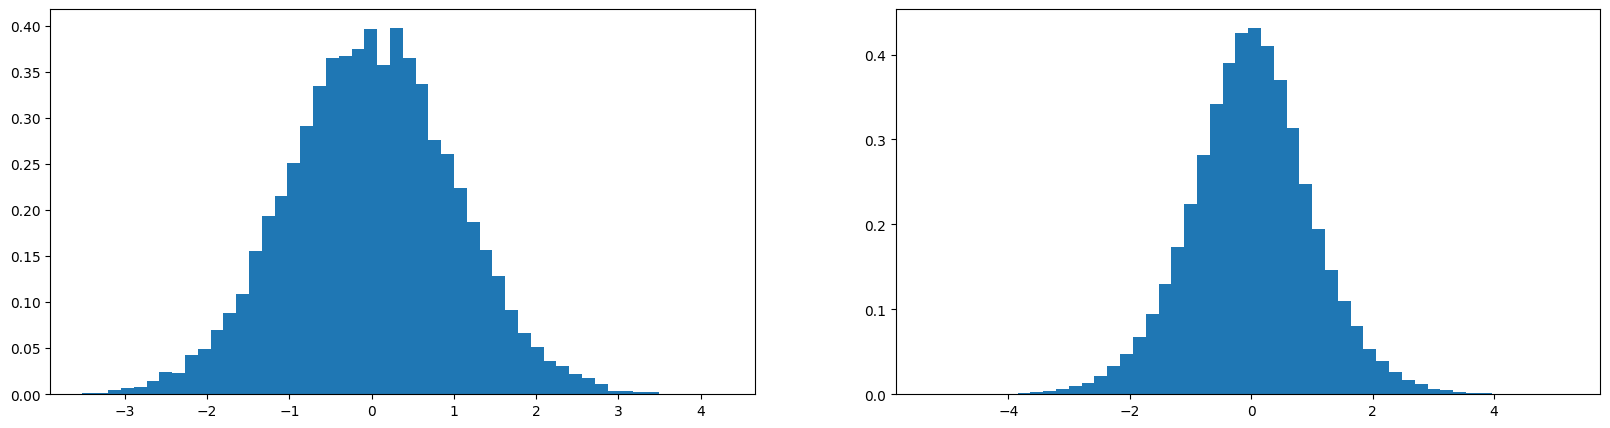

In [13]:
import matplotlib.pyplot as plt
x = torch.randn(1000,10)
# w = torch.randn(10,200)
# 为了解决矩阵乘法后std扩大的问题，需要除以一个缩放因子，就是fan in的平方根，这里的10就是fan in
w = torch.randn(10,200) / 10**0.5
y =  x @ w
print(f'mean of x is {x.mean()},std of x is {x.std()}')
print(f'mean of y is {y.mean()},std of y is {y.std()}')
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1),bins=50,density=True)
plt.subplot(122)
plt.hist(y.view(-1),bins=50,density=True)
# 可以看到经过矩阵运算后的y标准差变成了3倍


In [14]:
epoch = 20000
batch_size = 32
learning_rate = 0.1

In [ ]:
for _ in range(epoch):
    # build mini batch
    ix = torch.randint(0,Xtr.shape[0],(batch_size,))
    # forward pass
    emb = C[Xtr[ix]]
    hpreact = emb.view(emb.shape[0],input_neurons) @ w1 #+ b1 #因为这里后续会减去hpreact的均值，实际上b1在做完减法后被抵消了，并且batch normalization层中引入了一个bnbais进行横向的偏移
    # batch normalization layer
    # batch normalization的思想就是在激活函数之前，对数据进行归一化处理，使得数据的分布尽量集中在激活函数的梯度较大的范围内，而不是两端unhappy冷淡或者happy兴奋的区域。
    # 从实施上来说就是将数据减去均值，再除以标准差，但是这样会强制使得数据变成以均值为中心的分布，这破坏了神经网络拟合的能力；
    # 因此通过一个scaling factor来控制数据的分布范围，也就是“山峰”的宽度，再通过一个bias来控制'山峰'的左右移动；
    # 这样可以让数据的分布更加集中，但是又可以通过可学习的scaling factor和bias来控制数据的分布形态。
    bnmean_i = hpreact.mean(0,keepdim=True)
    bnstd_i = hpreact.std(0,keepdim=True)
    hpreact = bngain * (hpreact-bnmean_i)/bnstd_i + bnbias
    # 论文中提出的思路，不在最后使用全部批次的数据集计算bnmean和bnstd，而是使用近似估计的方式来计算bnmean和bnstd。
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmean_i
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstd_i
    # non-linearity
    h = torch.tanh(hpreact)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits,Ytr[ix])
    # print(f'loss = {loss}')
    # break
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += -learning_rate * p.grad
print(f'loss = {loss}')


loss = 2.4102935791015625


In [ ]:
# 最后训练完成后需要计算整体数据集的bnmean和bnstd用来进行validation和采样（可以采用动态计算的方式取消这一步的计算）
# with torch.no_grad():
#     emb = C[Xtr]
#     embcat = emb.view(emb.shape[0], -1)
#     hpreact = embcat @ w1 +b1
#     # 计算整个训练集上的batch norm的均值和标准差
#     bnmean = hpreact.mean(dim=0,keepdim=True)
#     bnstd = hpreact.std(dim=0,keepdim=True)

h_show shape is torch.Size([6400])


(array([180., 121., 106., 106., 106.,  98.,  68.,  71.,  84.,  74.,  59.,
         64.,  70.,  66.,  59.,  51.,  52.,  65.,  49.,  55.,  55.,  56.,
         51.,  52.,  55.,  54.,  47.,  60.,  53.,  45.,  54.,  53.,  56.,
         69.,  39.,  51.,  57.,  37.,  66.,  65.,  45.,  43.,  74.,  67.,
         59.,  49.,  55.,  89.,  66.,  76.,  71.,  51.,  53.,  49.,  45.,
         43.,  48.,  48.,  39.,  74.,  50.,  67.,  37.,  70.,  53.,  50.,
         45.,  49.,  36.,  60.,  48.,  55.,  60.,  62.,  37.,  45.,  41.,
         54.,  58.,  52.,  68.,  59.,  45.,  48.,  69.,  58.,  60.,  61.,
         59.,  65.,  55.,  68.,  72.,  95.,  73.,  77., 114., 101., 137.,
        164.]),
 array([-9.99913692e-01, -9.79918032e-01, -9.59922371e-01, -9.39926710e-01,
        -9.19931049e-01, -8.99935389e-01, -8.79939728e-01, -8.59944067e-01,
        -8.39948406e-01, -8.19952745e-01, -7.99957085e-01, -7.79961424e-01,
        -7.59965763e-01, -7.39970102e-01, -7.19974442e-01, -6.99978781e-01,
        -6.799

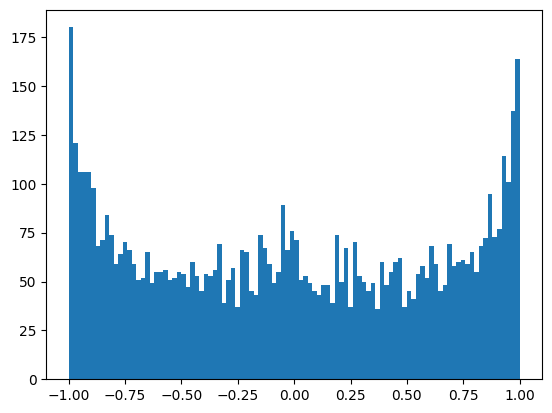

In [ ]:
import matplotlib.pyplot as plt

h_show = h.view(-1)
print(f'h_show shape is {h_show.shape}')

plt.hist(h_show.tolist(),100)

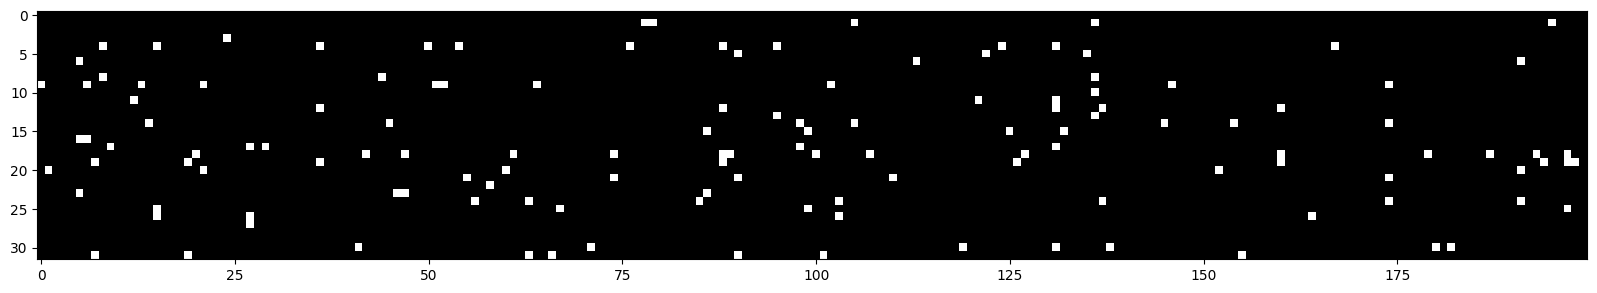

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99,cmap='gray',interpolation='nearest')

(array([  2.,   1.,   1.,   2.,   3.,   2.,   8.,   8.,   6.,  12.,  13.,
         30.,  27.,  34.,  56.,  55., 103.,  97., 162., 171., 225., 250.,
        288., 348., 404., 459., 622., 462., 429., 387., 335., 263., 228.,
        206., 151., 128.,  97.,  80.,  73.,  51.,  38.,  33.,  17.,   9.,
          6.,   4.,   2.,   5.,   4.,   3.]),
 array([-5.02533388, -4.83825311, -4.65117233, -4.46409156, -4.27701078,
        -4.08993001, -3.90284924, -3.71576846, -3.52868769, -3.34160691,
        -3.15452614, -2.96744536, -2.78036459, -2.59328382, -2.40620304,
        -2.21912227, -2.03204149, -1.84496072, -1.65787994, -1.47079917,
        -1.2837184 , -1.09663762, -0.90955685, -0.72247607, -0.5353953 ,
        -0.34831452, -0.16123375,  0.02584702,  0.2129278 ,  0.40000857,
         0.58708935,  0.77417012,  0.9612509 ,  1.14833167,  1.33541245,
         1.52249322,  1.70957399,  1.89665477,  2.08373554,  2.27081632,
         2.45789709,  2.64497787,  2.83205864,  3.01913941,  3.20622019,
 

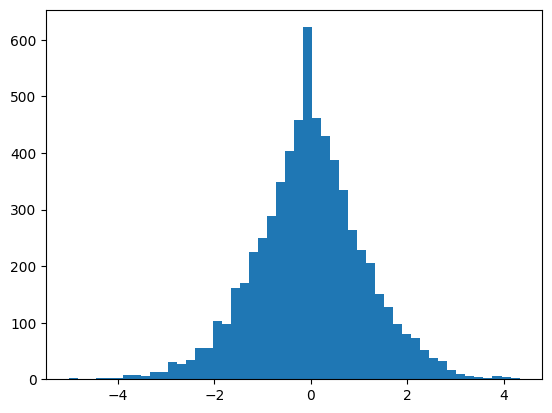

In [ ]:
plt.hist(hpreact.view(-1).tolist(),bins=50)

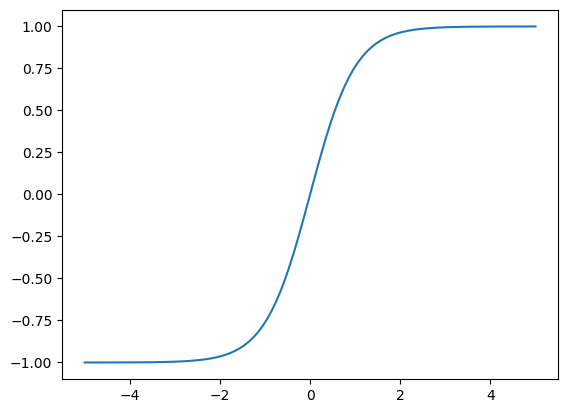

In [ ]:
import matplotlib.pyplot as plt

xi = torch.linspace(-5,5,100)
yi = torch.tanh(xi)
plt.plot(xi,yi)

In [ ]:
# 评估所有数据集的loss
emb = C[Xdev]
embcat = emb.view(emb.shape[0],input_neurons)
hpreact = embcat @ w1 +b1
# hpreact = bngain * (hpreact-bnmean)/bnstd + bnbias
hpreact = bngain * (hpreact - bnmean_running)/bnstd_running + bnbias
h = torch.tanh(hpreact)
logits = h @ w2 + b2
loss = F.cross_entropy(logits,Ydev)
print(f'loss = {loss}')

loss = 2.2315735816955566


In [ ]:
# generate sample
for i in range(10):
    str = ''
    start_chs = '...'
    while True:      
        x_start = C[torch.tensor([stoi(i) for i in start_chs])].view(1,-1).float()
        h1 = torch.tanh(x_start @ w1 +b1)
        logits = h1 @ w2 + b2
        prob = torch.exp(logits)/torch.sum(torch.exp(logits))
        ix = torch.multinomial(prob,num_samples=1,replacement=True)
        if ix == 0:
            print(str)
            break
        else:
            start_chs = start_chs[1:] + itos(ix)
        str += itos(ix)

fmmaldy
hrlordngty
frldchmm
jashan
khimfrutwessnnhanna
jamrrreskanjhosteffrystsmfrycg
mfrydn
ntresja
paurus
khll


## 总结：对象化代码，训练更深的神经网络

In [48]:
class Linear:
    def __init__(self,fan_in,fan_out,bias=True):
        self.weight = torch.randn((fan_in,fan_out))/fan_in**0.5
        if bias:
            self.bias = torch.zeros(fan_out)
        else:
            self.bias = None
    
    def __call__(self,x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is False else [self.bias])
    
    
class BatchNorm1d:
    def __init__(self,dim,eps=1e-5,momentum=0.001):
        self.eps = eps
        self.momentum = momentum
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.training = True
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self,x):
        if self.training:
            # batch mean and variance
            xmean = x.mean(0,keepdim=True)
            xvar = x.var(0,keepdim=True)    
        else:
            xmean = self.running_mean
            xvar = self.running_var
            
        # 动态计算总计样本的均值和方差
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        
        xhat = (x-xmean)/torch.sqrt(xvar+self.eps)
        self.out = self.gamma * xhat + self.beta
        
        return self.out
    
    def parameters(self):
        return [self.gamma,self.beta]
    
class Tanh():
    def __init__(self):
        pass
    
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [74]:
n_embed = 10
block_size = 3
input_neurons = n_embed * block_size
n_hidden = 100
epochs = 2000
batch_size = 32
learning_rate = 0.1

In [87]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embed),generator=g)

# layers = [Linear(input_neurons,n_hidden),BatchNorm1d(n_hidden),Tanh(),
#           Linear(n_hidden,n_hidden),BatchNorm1d(n_hidden),Tanh(),
#           Linear(n_hidden,n_hidden),BatchNorm1d(n_hidden),Tanh(),
#           Linear(n_hidden,n_hidden),BatchNorm1d(n_hidden),Tanh(),
#           Linear(n_hidden,n_hidden),BatchNorm1d(n_hidden),Tanh(),
#           Linear(n_hidden,vocab_size)]

layers = [Linear(input_neurons,n_hidden),BatchNorm1d(n_hidden),Tanh(),
          Linear(n_hidden,n_hidden),BatchNorm1d(n_hidden),Tanh(),
          Linear(n_hidden,n_hidden),BatchNorm1d(n_hidden),Tanh(),
          Linear(n_hidden,n_hidden),BatchNorm1d(n_hidden),Tanh(),
          Linear(n_hidden,n_hidden),BatchNorm1d(n_hidden),Tanh(),
          Linear(n_hidden,vocab_size)]

parameters = [C] + [p for layer in layers for p in layer.parameters()]

print(f'Sum of parameters:{sum(p.nelement() for p in parameters)}')
    
with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain of tanh
    for layer in layers[:-1]:
        if isinstance(layer,Linear):
            layer.weight *= 5/3
            
for p in parameters:
     p.requires_grad = True

Sum of parameters:47497


In [88]:
for _ in range(epochs):
    # build mini batch
    ix = torch.randint(0,Xtr.shape[0],(batch_size,))
    # forward pass
    emb = C[Xtr[ix]]
    x = emb.view(emb.shape[0],-1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x,Ytr[ix])
    
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
       p.data += -learning_rate * p.grad
    print(f'loss is {loss}')
    break
# print(f'loss is {loss}')

loss is 3.2897086143493652


In [ ]:
# visualize histograms
